In [1]:
import os
import sys
import tensorflow as tf

'''
Initial setup
'''
project_id = 'serene-athlete-271523'
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    
    drive.mount("/content/drive")
    os.chdir("/content/drive")

    base_drive = 'Shared drives/TCAV4OCT/'
    
    %tensorflow_version 1.15.2
elif not IN_COLAB:
    root_dir = '/home/jupyter/tcav_synced/'
    sync_me = True # switch to sync google vm with drive
    # 1. install command: curl https://rclone.org/install.sh | sudo bash
    # 2. follow instructions to set up credentials, use remote login in last step: https://rclone.org/drive/
    #!rclone sync tcav {root_dir} -P
    base_drive = root_dir
    if sync_me:
        !rclone copy tcav: {root_dir}
        print('done safe-syncing from drive to cloud')
        !rclone copy {root_dir} tcav:
        print('done safe-syncing from cloud to drive')
    else:
        print('not syncing')
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    if tf.test.gpu_device_name(): 
        print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
        print(tf.DeviceSpec(device_type="GPU", device_index=34343))
        gpus = True
        strategy = tf.distribute.MirroredStrategy()
    else:
        gpus = False
        print("Not using GPU version of TF")
    #!rclone copy {data_dir} midus:data  -P
    #!rclone copy {results_dir} midus:results -P
os.chdir(base_drive)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.2`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


# Dependencies

In [2]:
import pandas as pd
import glob
from PIL import Image
# this requires a cite, slightly modified from the github version
from utils.pygazeanalyser.gazeplotter import draw_fixations, draw_heatmap, draw_scanpath, draw_raw
import matplotlib.pyplot as plt


# Aggregate data

In [3]:
background_images_path = 'eyeTrackingHeatMapInfo/imagesSeenByExperts/G'
coordinate_path = 'eyeTrackingHeatMapInfo/expertSubjectCoordinateInfo'

# get the image size for scaling later
background_im = glob.glob(background_images_path+"/*.png")[6]
print(background_im)
with Image.open(background_im) as im:
    im_width, im_height = im.size

# coordinate data
merged_coord = pd.DataFrame()
pid = 0
for file in glob.glob(coordinate_path+"/*.xlsx"):
    sheets_dict = pd.read_excel(file, sheet_name=None)
    iid = 0
    for name, sheet in sheets_dict.items():
        sheet['pid'] = pid
        sheet['iid'] = iid
        print(pid)
        print(iid)
        merged_coord = merged_coord.append(sheet)
        iid += 1 # increment image ID
    pid += 1 # increment participant ID
merged_coord['im_pos_x'] = merged_coord['norm_pos_x']*im_width
merged_coord['im_pos_y'] = merged_coord['norm_pos_y']*im_height

# AOI (read from PDF for now)
rnfl_thickness_aoi = {'BottomLeftX': 0.3159, 'BottomLeftY': 0.0160, 'TopLeftX': 0.3159, 'TopLeftY': 0.2521, 'TopRightX': 0.4903, 'TopRightY': 0.2521, 
                      'BottomRightX': 0.4903, 'BottomRightY': 0.0160}
rnfl_prob_aoi = {'BottomLeftX': 0.6955, 'BottomLeftY': 0.4365, 'TopLeftX': 0.6955, 'TopLeftY': 0.6762, 'TopRightX': 0.8739, 'TopRightY': 0.6762, 
                 'BottomRightX': 0.8739, 'BottomRightY': 0.4365}
rgcp_prob_aoi = {'BottomLeftX': 0.7779, 'BottomLeftY': 0.0142, 'TopLeftX': 0.7779, 'TopLeftY': 0.2301, 'TopRightX': 0.8996, 'TopRightY': 0.2301, 
                 'BottomRightX': 0.8996, 'BottomRightY': 0.0142}
rgcp_thickness_aoi = {'BottomLeftX': 0.6221, 'BottomLeftY': 0.0160, 'TopLeftX': 0.6221, 'TopLeftY': 0.2301, 'TopRightX': 0.7442, 'TopRightY': 0.2301,
                      'BottomRightX': 0.7442, 'BottomRightY': 0.0160}
cpRNFL_thickness_aoi = {'BottomLeftX': 0.09239, 'BottomLeftY': 0.43, 'TopLeftX': 0.09239, 'TopLeftY': 0.7871, 'TopRightX': 0.5327, 'TopRightY': 0.7871, 
                        'BottomRightX': 0.5327, 'BottomRightY': 0.43}                      

eyeTrackingHeatMapInfo/imagesSeenByExperts/G/1.png
0
0
0
1
0
2
0
3
0
4
0
5
0
6
0
7
1
0
1
1
1
2
1
3
1
4
1
5
1
6
1
7


eyeTrackingHeatMapInfo/imagesSeenByExperts/G/0.png


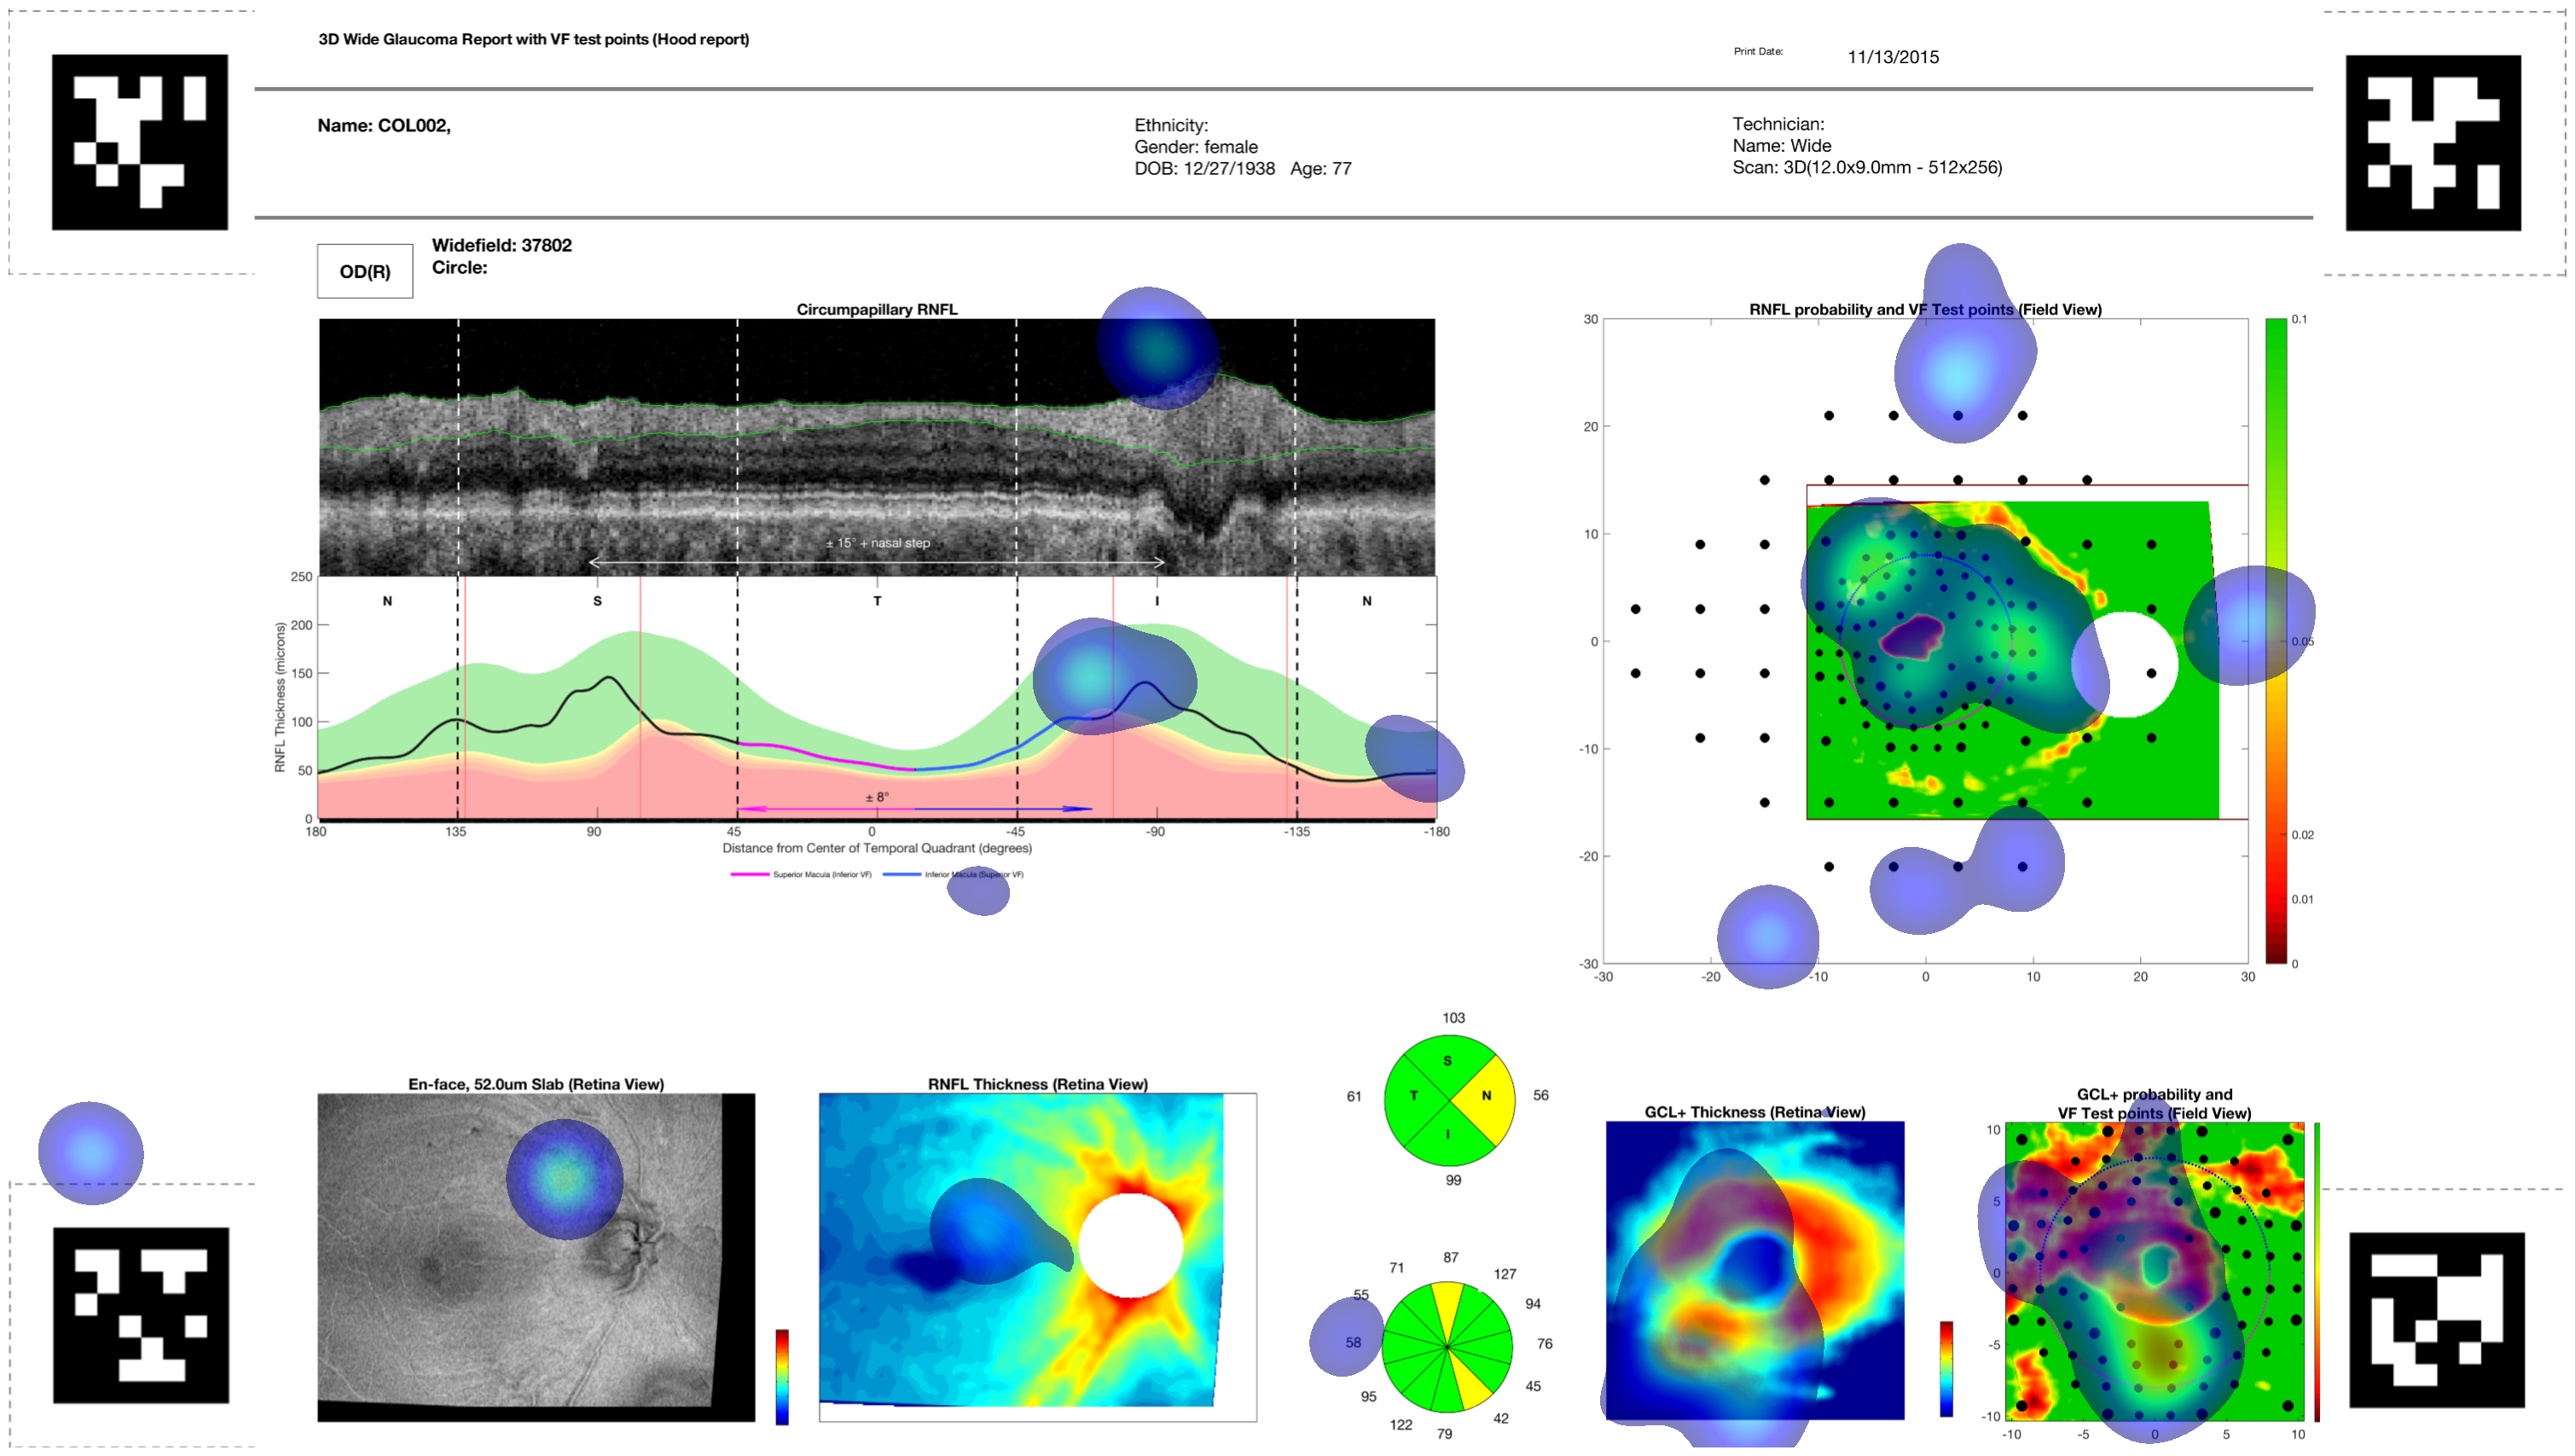

In [5]:
# get the image size for scaling later
background_im = glob.glob(background_images_path+"/*.png")[5]
print(background_im)
with Image.open(background_im) as im:
    im_width, im_height = im.size

# first participant, first sheet for sanity check
sub_df = merged_coord.copy()
sub_df = sub_df.loc[(sub_df['pid'] == 0) & (sub_df['iid'] == 0)]
draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=background_im, alpha=0.5, savefilename=None)

# aggregated heatmap
#sub_df = merged_coord.copy()
#draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=background_im, alpha=0.5, savefilename=None)

In [ ]:
background_im = glob.glob(background_images_path+"/*.png")[6]
print(background_im)
with Image.open(background_im) as im:
    im_width, im_height = im.size

sub_df = merged_coord.copy()
sub_df = sub_df.loc[(sub_df['pid'] == 0) & (sub_df['iid'] == 1)]
draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=background_im, alpha=0.5, savefilename=None)


In [ ]:
background_im = glob.glob(background_images_path+"/*.png")[7]
print(background_im)
with Image.open(background_im) as im:
    im_width, im_height = im.size

sub_df = merged_coord.copy()
sub_df = sub_df.loc[(sub_df['pid'] == 0) & (sub_df['iid'] == 3)]
draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=background_im, alpha=0.5, savefilename=None)


In [ ]:
background_im = glob.glob(background_images_path+"/*.png")[0]
print(background_im)
with Image.open(background_im) as im:
    im_width, im_height = im.size

sub_df = merged_coord.copy()
sub_df = sub_df.loc[(sub_df['pid'] == 0) & (sub_df['iid'] == 4)]
draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=background_im, alpha=0.5, savefilename=None)


In [ ]:
background_im = glob.glob(background_images_path+"/*.png")[1]
print(background_im)
with Image.open(background_im) as im:
    im_width, im_height = im.size

sub_df = merged_coord.copy()
sub_df = sub_df.loc[(sub_df['pid'] == 0) & (sub_df['iid'] == 5)]
draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=background_im, alpha=0.5, savefilename=None)


In [ ]:
background_im = glob.glob(background_images_path+"/*.png")[2]
print(background_im)
with Image.open(background_im) as im:
    im_width, im_height = im.size

sub_df = merged_coord.copy()
sub_df = sub_df.loc[(sub_df['pid'] == 0) & (sub_df['iid'] == 2)]
draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=background_im, alpha=0.5, savefilename=None)


In [ ]:
background_im = glob.glob(background_images_path+"/*.png")[3]
print(background_im)
with Image.open(background_im) as im:
    im_width, im_height = im.size

sub_df = merged_coord.copy()
sub_df = sub_df.loc[(sub_df['pid'] == 0) & (sub_df['iid'] == 6)]
draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=background_im, alpha=0.5, savefilename=None)


In [ ]:
background_im = glob.glob(background_images_path+"/*.png")[4]
print(background_im)
with Image.open(background_im) as im:
    im_width, im_height = im.size

sub_df = merged_coord.copy()
sub_df = sub_df.loc[(sub_df['pid'] == 0) & (sub_df['iid'] == 7)]
draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=background_im, alpha=0.5, savefilename=None)


In [4]:
def label_aoi(row):
    def check_aoi(aoi_dict, norm_x, norm_y):
        norm_y=1-norm_y
        return aoi_dict['TopLeftX'] <= norm_x and norm_x <= aoi_dict['BottomRightX'] and 1-aoi_dict['TopLeftY'] <= norm_y and norm_y <= 1-aoi_dict['BottomRightY']
    if check_aoi(rnfl_thickness_aoi, row['norm_pos_x'], row['norm_pos_y']):
        return 'rnfl_thickness_aoi'
    elif check_aoi(rnfl_prob_aoi, row['norm_pos_x'], row['norm_pos_y']):
        return 'rnfl_prob_aoi'
    elif check_aoi(rgcp_prob_aoi, row['norm_pos_x'], row['norm_pos_y']):
        return 'rgcp_prob_aoi'
    elif check_aoi(rgcp_thickness_aoi, row['norm_pos_x'], row['norm_pos_y']):
        return 'rgcp_thickness_aoi'
    elif check_aoi(cpRNFL_thickness_aoi, row['norm_pos_x'], row['norm_pos_y']):
        return 'cpRNFL_thickness_aoi'
    return 'no_aoi'

merged_coord['label_aoi']=merged_coord.apply(lambda row: label_aoi(row), axis=1)
merged_coord.groupby('label_aoi').agg(['mean', 'count'])['duration']

,mean,count
label_aoi,,
cpRNFL_thickness_aoi,195.383876,1786
no_aoi,194.092393,2727
rgcp_prob_aoi,192.811203,554
rgcp_thickness_aoi,194.866541,612
rnfl_prob_aoi,194.131004,845
rnfl_thickness_aoi,193.352425,281
